# Deep Deterministic Policy Gradients (DDPG)
---
In this notebook, we train DDPG with OpenAI Gym's BipedalWalker-v2 environment.

### 1. Import the Necessary Packages

In [1]:
# render ai gym environment
#!pip install gymnasium[box2d]
import gymnasium as gym

#!pip install progressbar
#import progressbar as pb
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import deque, defaultdict
import random
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib inline

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display
else:  
    #!python -m pip install pyvirtualdisplay
    from pyvirtualdisplay import Display
    display = Display(visible=True, size=(1400, 900))
    display.start()
    
_=plt.ion()

# install package for displaying animation
#!pip install JSAnimation
from JSAnimation.IPython_display import display_animation

#ddpg_agent_lunar 
#from ddpg_agent_lunar import *
import ddpg_agent
from ddpg_agent import Agent, device, BUFFER_SIZE, SEED

print("Using device {} from ddpg_agent".format(device)) 


Using device cuda:0 from ddpg_agent


If *continuous=True* is passed, continuous actions (corresponding to the throttle of the engines) will be used and the action space will be `Box(-1, +1, (2,), dtype=np.float32)`. 

The **first coordinate** of an action determines the **throttle of the main engine**, while the **second** coordinate specifies the **throttle of the lateral boosters**. 

Given an action `np.array([main, lateral])`, the main engine will be turned off completely if **main < 0** and the throttle scales affinely from **50% to 100%** for **0 <= main <= 1** (in particular, the main engine doesn’t work with **less than 50% power**). 

Similarly, if **-0.5 < lateral < 0.5**, the lateral boosters will not fire at all. If **lateral < -0.5**, the **left booster** will fire, and if **lateral > 0.5**, the **right booster** will fire. Again, the throttle scales affinely from **50% to 100%** between **-1 and -0.5** (and **0.5 and 1**, respectively).

*gravity* dictates the gravitational constant, this is bounded to be within **0 and -12.**

If *enable_wind=True* is passed, there will be wind effects applied to the lander. The wind is generated using the function `tanh(sin(2 k (t+C)) + sin(pi k (t+C)))`. **k** is set to **0.01**. **C** is sampled randomly between **-9999 and 9999**.

*wind_power* dictates the maximum magnitude of linear wind applied to the craft. The recommended value for *wind_power* is between **0.0 and 20.0**. 

*turbulence_power* dictates the maximum magnitude of rotational wind applied to the craft. The recommended value for *turbulence_power* is between **0.0 and 2.0**.

### 2. Instantiate the Environment and Agent

In [2]:
env = gym.make('LunarLanderContinuous-v2', render_mode="rgb_array")
seed=SEED
state_size=env.observation_space.shape[0]
action_size=env.action_space.shape[0]
print(state_size, action_size)
agent = Agent(  state_size=state_size, action_size=action_size, random_seed=SEED,
                actor_units_in=256, actor_units_hid=128,
                critic_units_in=512, critic_units_hid=128
             )

8 2


In [4]:
#agent.actor_local.load_state_dict(torch.load('data/highscore_actor.pth'))#, map_location=torch.device('cpu')))
#agent.critic_local.load_state_dict(torch.load('data/highscore_critic.pth'))#, map_location=torch.device('cpu')))

actor_local_params = [p for p in agent.actor_local.parameters()]
actor_target_params = [p for p in agent.actor_target.parameters()]
#print(actor_local_params[-1])
#print(actor_target_params[-1])
for x, y in zip(agent.actor_local.parameters(), agent.actor_target.parameters()):
    print("Shape", x.shape, "  Equal", sum(x==y))

Parameter containing:
tensor([-0.0082, -0.0216], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.0082, -0.0216], device='cuda:0', requires_grad=True)
Shape torch.Size([256, 8])   Equal tensor([256, 256, 256, 256, 256, 256, 256, 256], device='cuda:0')
Shape torch.Size([256])   Equal tensor(256, device='cuda:0')
Shape torch.Size([128, 256])   Equal tensor([128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
     

### 3. Train the Agent with DDPG

Run the code cell below to train the agent from scratch.  Alternatively, you can skip to the next code cell to load the pre-trained weights from file.

In [5]:
def dqn(n_episodes=2000, max_t=1000):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
    """
    FIRST = True
    start = time.time()
    episode_times = []; episode_lengths = []; scores = []; action_steps = []; noise_steps= []; actor_loss = []; critic_loss = []
    scores_window = deque(maxlen=100)
    
    for i_episode in range(1, n_episodes+1):
        epistart = time.time()
        state, _ = env.reset(seed=SEED)
        score = 0; episteps = 0; a_loss = 0 ; c_loss = 0
        for t in range(max_t):
            action, noise = agent.act(state, return_noise=True)
            action_steps.append(action)
            noise_steps.append(noise)
            action = np.clip(action+noise, -1, 1)
            next_state, reward, done, trun, _ = env.step(action)
            al, cl = agent.step(state, action, reward, next_state, done or trun, return_loss=True)
            if al != None: 
                a_loss += al; c_loss += cl; 
            state = next_state; score += reward; episteps += 1
            if done or trun:
                break              
        
        # Data appendage
        scores_window.append(score)       
        scores.append(score)
        episode_lengths.append(episteps)
        actor_loss.append(a_loss/episteps)          
        critic_loss.append(c_loss/episteps)
        if np.abs(actor_loss[-1]) > 1e9 or np.abs(critic_loss[-1]) > 1e9: break
        episode_times.append(time.time()-epistart)
        
        cycle_steps = agent.steps%BUFFER_SIZE
        buffer_cycle = agent.steps//BUFFER_SIZE

        print("\rEpisode {:4d} | Score:{:8.2f} | Actor Loss:{:8.2f} | Critic Loss:{:8.2f} | Episode: {:4d} Steps in {:5.3f} sec | Memory Buffer:{:7d} into cycle {:3d}".format(i_episode,
                                                                                                                                                                                score, actor_loss[-1], critic_loss[-1],
                                                                                                                                                                                episteps, time.time()-epistart,
                                                                                                                                                                                cycle_steps, buffer_cycle), end="")
                                                                                                                                        
        if i_episode % 10 == 0:
            chkpntname = "data/actor_chkpnt{}.pth".format(i_episode)
            torch.save(agent.actor_target.state_dict(), chkpntname)  
            chkpntname = "data/critic_chkpnt{}.pth".format(i_episode)
            torch.save(agent.critic_target.state_dict(), chkpntname) 
            print("\rEpisode {:4d} | Score: {:8.2f} | Actor Loss: {:8.2f} | Critic Loss: {:8.2f} | Average: {:5.1f} Steps in {:5.3f} sec | Memory Buffer:{:7d} into cycle {:3d}".format(i_episode, 
                                                                                                                                                                                    np.mean(scores_window), np.mean(actor_loss), np.mean(critic_loss),
                                                                                                                                                                                    np.mean(episode_lengths), np.mean(episode_times),
                                                                                                                                                                                    cycle_steps, buffer_cycle))
        
        if np.mean(scores_window)>=100. and FIRST:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:5.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.actor_target.state_dict(), 'data/actor_slvdpnt.pth')
            torch.save(agent.critic_target.state_dict(), 'data/critic_slvdpnt.pth')
            FIRST = False
        elif np.mean(scores_window)>=150. :
            print("\n***** High Score! *****")
            print("\tGame over.")
            torch.save(agent.actor_target.state_dict(), 'data/actor_hipnt.pth')
            torch.save(agent.critic_target.state_dict(), 'data/critic_hipnt.pth')
            break
            
    t_time = time.time() - start
    print("Total time: {:3d} minutes {:4.2f} seconds \tAvg. Episode time: {:5.3f} seconds \tAvg. Episode steps: {:5.3f}".format(int(t_time//60),
                                                                                                                                   t_time%60,
                                                                                                                                   t_time/i_episode,
                                                                                                                                   agent.steps/i_episode))
    return scores, episode_lengths, episode_times, action_steps, noise_steps, actor_loss, critic_loss

In [ ]:
state, _ = env.reset()  #seed=SEED), noise
action, noise = agent.act(state, return_noise=True)
next_state, reward, done, trun, _ = env.step(action+noise)
print(action, "\t", np.clip(action+noise,-1,1))
print("{}\n{}\n{}\n{}\n{}\n{}\n".format(state, action, noise, reward, next_state, done or trun))
al, cl = agent.step(state, action, reward, next_state, done or trun, return_loss=True)
print("{}\n{}\n".format(al, cl))

In [ ]:
#actions_next = self.
next_state = torch.from_numpy(next_state).to(device)
print(agent.actor_target(next_state), agent.actor_local(next_state))
next_state = next_state.detach().cpu().numpy() #.data
#next_state
#Q_targets_next = self.critic_target(next_states, actions_next)

In [6]:
############### Train "DQN-style"
n_episodes=1000
max_t=1000
print('\r### Episodes: {}\tTime Limit: {:.2f} ###'.format(n_episodes, max_t))
new_scores, new_els, new_ets, new_as, new_ns, new_al, new_cl = dqn(n_episodes, max_t)
try:
    scores += new_scores ; episode_lengths += new_els ; episode_times += new_ets ; action_steps += new_as ; noise_steps+=new_ns ; actor_loss += new_al ; critic_loss += new_cl
except:
    scores = new_scores ; episode_lengths = new_els ; episode_times = new_ets ; action_steps = new_as ; noise_steps = new_ns ; actor_loss = new_al ; critic_loss = new_cl

### Episodes: 1000	Time Limit: 1000.00 ###
Episode   10 | Score:  -249.70 | Actor Loss:     2.22 | Critic Loss:    63.19 | Average: 124.0 Steps in 1.121 sec | Memory Buffer:   1240 into cycle   0
Episode   20 | Score:  -254.75 | Actor Loss:     3.15 | Critic Loss:    62.72 | Average: 121.5 Steps in 1.097 sec | Memory Buffer:   2431 into cycle   0
Episode   30 | Score:  -275.93 | Actor Loss:     4.22 | Critic Loss:    59.04 | Average: 120.6 Steps in 1.088 sec | Memory Buffer:   3619 into cycle   0
Episode   40 | Score:  -273.25 | Actor Loss:     5.36 | Critic Loss:    53.99 | Average: 116.8 Steps in 1.048 sec | Memory Buffer:   4673 into cycle   0
Episode   50 | Score:  -278.89 | Actor Loss:     6.45 | Critic Loss:    50.51 | Average: 116.8 Steps in 1.046 sec | Memory Buffer:   5842 into cycle   0
Episode   60 | Score:  -283.62 | Actor Loss:     7.55 | Critic Loss:    46.88 | Average: 115.6 Steps in 1.034 sec | Memory Buffer:   6938 into cycle   0
Episode   70 | Score:  -284.62 | Actor 

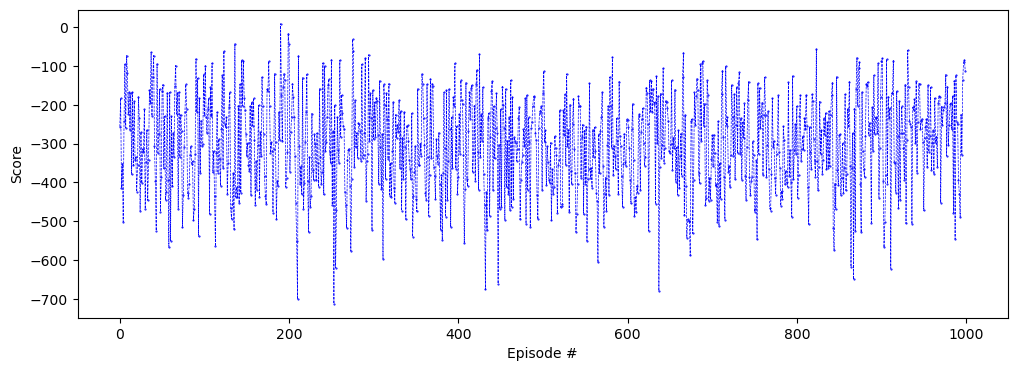

In [7]:
# plot the scores
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, 'b.--', linewidth=0.5, markersize=1.0)
plt.ylabel('Score')
plt.xlabel('Episode #')
#plt.xlim(0,25)
plt.show()


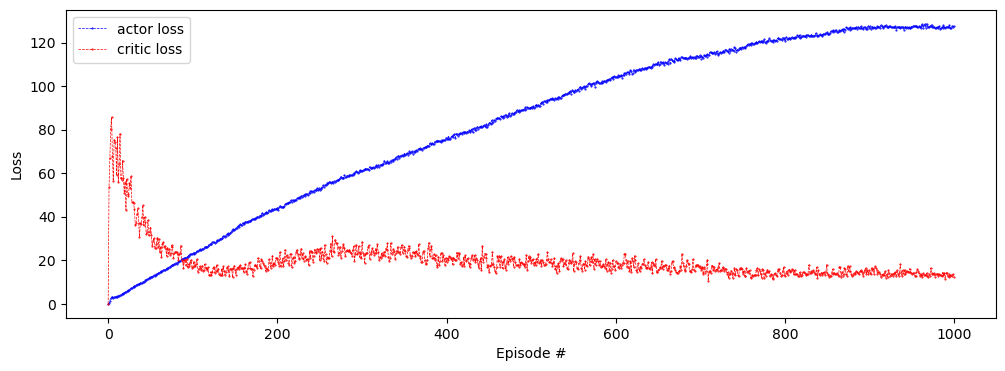

In [8]:
# plot the loss
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(actor_loss)), actor_loss, 'b.--', linewidth=0.5, markersize=1.0)
plt.plot(np.arange(len(critic_loss)), critic_loss, 'r.--', linewidth=0.5, markersize=1.0)
plt.ylabel('Loss')
plt.xlabel('Episode #')
plt.legend(["actor loss", "critic loss"])
plt.show()

## Data

In [ ]:
states, actions, rewards, next_states, dones = zip(*agent.memory.memory)

In [ ]:
memsam = agent.memory.sample(), len(agent.memory)

#[(r, a[0], a[1]) for r,a in zip(norm(rewards[100:-100]), actions[100:-100]) if a[0]!=1 and (a[1]>=0.5 or a[1]<=-0.5)]
#np.mean([r for r,a in zip(rewards,actions) if a[0]>=0.5]), np.mean(rewards)
#sum(actions[0])

## Plots

In [9]:
sum([a[0] for a in action_steps])

0.0

C:\Users\David\AppData\Local\Temp\ipykernel_10396\3783817990.py:31: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  plt.ylim(*ylims)


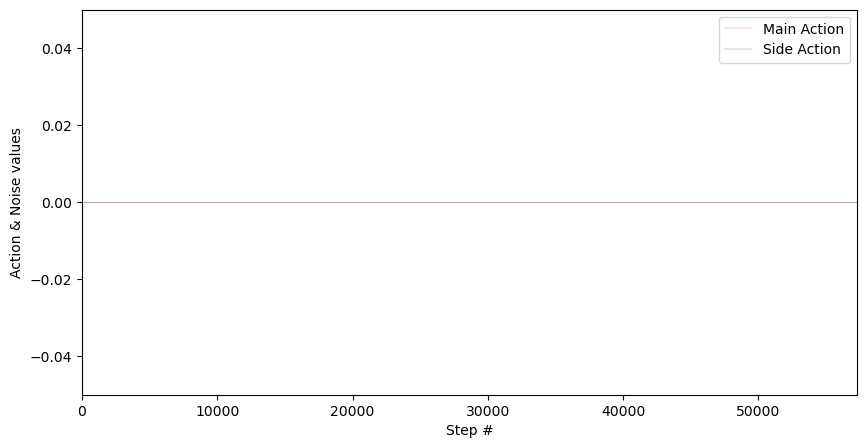

In [11]:
### Action / Noise plot

### action_noise array shape(50000, (a0,a1), (n0,n1))
#action_noise[-10:,0,:] + action_noise[-10:,1,:], len(actions), len(action_noise)

#act=[(a[0],a[1]) for a in action_noise[:,0]]
#noi=[(n[0],n[1]) for n in action_noise[:,1]]

mact= [a[0] for a in action_steps]
mnoi= [n[0] for n in noise_steps]
sact= [a[1] for a in action_steps]
snoi= [n[1] for n in noise_steps]
dim0= len(mact) #action_noise.shape[0]
x= np.arange(1, dim0+1)

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
plt.plot(x, mact, linewidth=0.25, markersize=0.6,alpha=0.6,c='#a00')#
plt.plot(x, sact, linewidth=0.25, markersize=0.6,alpha=0.6,c='#005')
#plt.plot(x, mnoi, linewidth=0.1, markersize=0.3,alpha=0.6,c='#a50',)#, 
#plt.plot(x, snoi, linewidth=0.1, markersize=0.3,alpha=0.6,c='#055')
ax.legend(["Main Action", "Side Action"])#, "Main Noise","Side Noise"])
plt.ylabel('Action & Noise values')
plt.xlabel('Step #')

lim = dim0 #len(mact)
xlims = (0,lim)
ylims = (round(min( min(mact[:lim]), min(sact[:lim]) )),
            round(max( max(mact[:lim]), max(sact[:lim]) )))
plt.xlim(*xlims)
plt.ylim(*ylims)
plt.show()

In [ ]:
###  plot
m_power = lambda m: (np.clip(m, 0.0, 1.0) + 1.0) * 0.5
sigmoid = lambda x: 1 / (1 + np.exp(-x))
tanh = lambda x: np.tanh(x)

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
mact= [a[0]+n[0] for a, n in zip(act, noi)]
mnoi= [n[0] for n in noi]
sact= [a[1]+n[1] for a, n in zip(act, noi)]
snoi= [n[1] for n in noi]
dim1= 6000               #len(act) #action_noise.shape[0]
x= np.arange(1, dim1+1)
plt.plot(x, mnoi[1:dim1+1], linewidth=0.25, markersize=0.33, alpha=0.6, c='#00a')
plt.plot(x, snoi[1:dim1+1], linewidth=0.25, markersize=0.33, alpha=0.6, c='#d44')

#plt.plot(x, mnoi, linewidth=0.1, markersize=0.3,)#, 
#plt.plot(x, snoi, linewidth=0.1, markersize=0.3,)
#[sigmoid(m) for m in main]
#[tanh(s) for s in side]
#plt.plot(np.arange(1, dim1+1), main[1:dim1+1], linewidth=0.25, markersize=0.33, alpha=0.33, c='#a00')#
#plt.plot(np.arange(1, dim1+1), side[1:dim1+1], linewidth=0.25, markersize=0.75, alpha=0.4, c='#911')#, 

ax.legend(["mact-mnoi","sact-snoi","main", "side"])
plt.ylabel('Functions(Actions)')
plt.xlabel('Step#')
plt.show()


In [ ]:
### Actions plot
main = [a[0] for a in actions]
side = [a[1] for a in actions]
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(actions)+1), main, linewidth=0.25, markersize=0.5,alpha=1.)#
plt.plot(np.arange(1, len(actions)+1), side, linewidth=0.25, markersize=0.5,alpha=1.)#, 
ax.legend(["main", "side"])
plt.ylabel('Action values')
plt.xlabel('Step #')
lim = 16000#len(actions)+1
xlims = (0,lim)
ylims = (round(min(side[:lim])), round(max(main[:lim])))
plt.xlim(*xlims)
plt.ylim(*ylims)
plt.show()


In [ ]:
###  plot LOSS
#pvs = [p for p in agent.memory.priorities.values()]
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(rewards)+1), norm(rewards), 
         'b,', linewidth=0.1, markersize=0.25,)
lim = len(rewards)+1
xlims = (0,lim)#2000)
ylims = (round(min(norm(rewards)[:lim])), round(max(norm(rewards[:lim]))))
#plt.xlim(*xlims)
#plt.ylim(*ylims)
plt.ylabel('Step rewards normed')
plt.xlabel('Step #')
plt.show()

In [ ]:
###  plot
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(priorities)+1), priorities, 'b,', linewidth=0.1, markersize=0.25,)
lim = len(priorities)+1 #10000
xlims = (0,lim)
ylims = (round(min(priorities[:lim])),round(max(priorities[:lim])))
#plt.xlim(*xlims)
plt.ylim(*ylims)
plt.ylabel('Priority')
plt.xlabel('Buffer #')
plt.show()

## 4. Watch a Smart Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent!

In [ ]:
#torch.save(agent.actor_local.state_dict(), 'data/checkpoint_actor.pth')
#torch.save(agent.critic_local.state_dict(), 'data/checkpoint_critic.pth'))
#agent.actor_local.load_state_dict(torch.load('data/actor_chkpnt300.pth'))
#agent.critic_local.load_state_dict(torch.load('data/critic_chkpnt300.pth'))

actor_local_params = [p for p in agent.actor_local.parameters()]
actor_target_params = [p for p in agent.actor_target.parameters()]
print(actor_local_params[-1])
print(actor_target_params[-1])
#print(actor_local_params[0]==actor_target_params[0])

In [ ]:
critic_local_params = [p for p in agent.critic_local.parameters()]
critic_target_params = [p for p in agent.critic_target.parameters()]
print(critic_local_params[-1])
print(critic_target_params[-1])
#print(critic_local_params[0]==critic_target_params[0])

Total episode reward:  -435.993


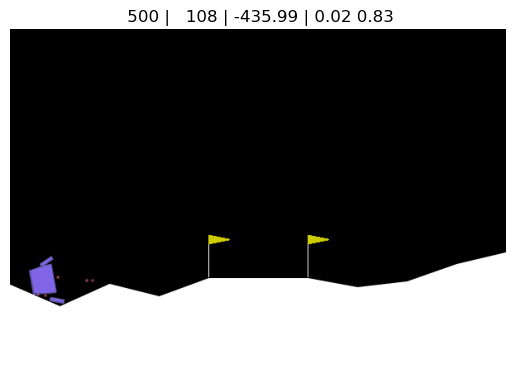

In [11]:
#### Display from DQN notebook
#chkpnt_name = "data/slvdpnt.pth"#"data/chkpnt{}.pth".format(chkpnt)  #
#agent.qnetwork_local.load_state_dict(torch.load(chkpnt_name))

# load the weights from file
#agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

# watch a pre-trained agent

for chkpnt in [100,300,500]:#range(100,1000,300):
#for agent in enumerate(agents):    
    chkpnt_name = "data/actor_chkpnt{}.pth".format(chkpnt)
    agent.actor_local.load_state_dict(torch.load(chkpnt_name))
    chkpnt_name = "data/critic_chkpnt{}.pth".format(chkpnt)
    agent.critic_local.load_state_dict(torch.load(chkpnt_name))
    score = 0
    state, _ = env.reset()
    img = plt.imshow(env.render())
    for j in range(1000):
        action = agent.act(state)
        state, reward, done, trun, _ = env.step(action)
        score += reward
        img.set_data(env.render()) 
        plt.axis('off')
        title = "{:4d} | {:5d} | {:7.2f} | {:2.2f} {:2.2f}".format(chkpnt, j+1, score, action[0], action[1])
        plt.title(title)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        if done or trun:
            break 
print("Total episode reward: ", np.round(np.sum(score),3))

In [ ]:
state, _ = env.reset()
img=env.render()
plt.imshow(img)

In [ ]:
#### Get data
rewards = []
final_rewards = []
steps = []
actions = []
tries = 100
max_t = 400
for i in range(tries):
    step_count = 0
    reward_sum = 0
    state, info = env.reset(seed=seed)
    for j in range(max_t):
        action = agent.act(state)
        actions += [action]
        state, reward, done, trun, info = env.step(action)
        if done or trun:
            final_rewards += [reward]
            break 
        else:
            final_rewards += [0]
            reward_sum += reward
            step_count += 1
    steps += [step_count]
    rewards += [reward_sum]
actions = np.asarray(actions)
data = np.asarray([(int(s),r),int(f)) for s,r,f in zip(steps, np.round(rewards,3), final_rewards)])

NameError: name 'scale_input' is not defined

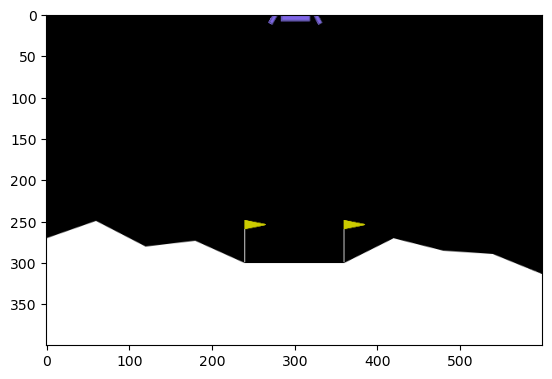

In [12]:
### Observe agent gameplay
pix_norm = lambda x: x/255.
SEED=1234
t = 500
smax = nn.Softmax(dim=1)

state, _ = env.reset(seed=SEED)
frame = env.render()
img = plt.imshow(pix_norm(frame))
action =  [random.random(), 2*random.random()-1]
for _ in range(t):
    state1, reward1, is_done, is_trunc, info = env.step(action)
    frame1 =  pix_norm(env.render())
    state2, reward2, is_done, is_trunc, info = env.step((0,0))
    frame2 =  pix_norm(env.render())
    states = np.asarray([scale_input(state1),
                         scale_input(state2)])
    action = [np.round(a,3) for a in agent.act(state2)]
    #pols = smax(sigs).detach().cpu().numpy()
    #probs = probs.detach().cpu().numpy()
    #action = np.argmax(probs[-1])
    
    #reward = reward2 + reward1
    
    frame = scale(frame2-frame1/2)
    img.set_data(frame)
    plt.title("M:"+str(action[0])+" S:"+str(action[1])+" R:"+str(np.round(reward1, 3)))
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)

    if is_done or is_trunc:
        break 

In [ ]:
m_powers = [(np.clip(a[0], 0.0, 1.0) + 1.0) * 0.5  for a in actions] ### 0.5..1.0 ### ??
[(a[0], mp) for a, mp in zip(actions, m_powers)]

In [ ]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(rewards[:-1])+1), rewards[:-1])
plt.ylabel('Score')
plt.xlabel('Step #')
plt.show()
print("Total Rewards[:-1]", sum(rewards[:-1]), "Final Reward:", rewards[-1])

# 5. Explore

In this exercise, we have provided a sample DDPG agent and demonstrated how to use it to solve an OpenAI Gym environment.  To continue your learning, you are encouraged to complete any (or all!) of the following tasks:
- **Amend the various hyperparameters and network architecture to see if you can get your agent to solve the environment faster than this benchmark implementation.**  Once you build intuition for the hyperparameters that work well with this environment, try solving a different OpenAI Gym task!
- Write your own DDPG implementation.  Use this code as reference only when needed -- try as much as you can to write your own algorithm from scratch.
- You may also like to implement **prioritized experience replay**, to see if it speeds learning.  
- The current implementation adds Ornsetein-Uhlenbeck noise to the action space.  However, it has [been shown](https://blog.openai.com/better-exploration-with-parameter-noise/) that **adding noise to the parameters of the neural network policy can improve performance.  Make this change to the code, to verify it for yourself!**
- Write a blog post explaining the intuition behind the DDPG algorithm and demonstrating how to use it to solve an RL environment of your choosing.  

## How well does DQN with Tile Coding how well does work?
* **Answer: S L O W**
* Reuse DQN from Project 1, but use Tile Coding to turn continuous into discrete actions
* Implement improvements on DQN from Project 1 first